# Simple RNN

Simple RNN that predicts the next character. Based on chapter 8 of Dive to Deep learning.

## Preparing dataset

For dataset here I used 3 books by Verne. They are contained in dataset directory as text files.

In order to use this dataset for training we need to do the following:

 - Load files into memory.
 - Split string into tokens (in this case characters).
 - Encode characters into numbers.
 
First let's load the files.

In [1]:
%matplotlib inline
import collections
import re
import glob
import random
import torch
import math
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from torch.nn import functional as torch_fn

device = "cuda" if torch.cuda.is_available() else "cpu"

DATASET_DIR = "dataset"

dataset_lines = []

for filename in glob.iglob(f'{DATASET_DIR}/*.txt'):
    print(f"Loading {filename} ...")
    with open(filename, 'r') as f:
        lines = f.readlines()
    file_lines = [re.sub('[^A-Za-z0-9]+', ' ', line).strip().lower() for line in lines]
    dataset_lines.extend(file_lines)

Loading dataset/around_the_world_in_80_days.txt ...
Loading dataset/journey_to_the_center_of_the_earth.txt ...
Loading dataset/the_secret_of_the_island.txt ...


In [2]:
len(dataset_lines)

26647

In [3]:
dataset_lines[:10]

['the project gutenberg ebook of around the world in 80 days by jules verne',
 '',
 'this ebook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever you may copy it give it away or',
 're use it under the terms of the project gutenberg license included',
 'with this ebook or online at www gutenberg net',
 '',
 '',
 'title around the world in 80 days',
 '']

Now we will tokenize and flatten the entire dataset.

In [4]:
tokenized_dataset = [list(line) for line in dataset_lines]
tokenized_dataset = [token for line in tokenized_dataset for token in line]

In [5]:
len(tokenized_dataset)

1141456

In [6]:
print(tokenized_dataset[:100])

['t', 'h', 'e', ' ', 'p', 'r', 'o', 'j', 'e', 'c', 't', ' ', 'g', 'u', 't', 'e', 'n', 'b', 'e', 'r', 'g', ' ', 'e', 'b', 'o', 'o', 'k', ' ', 'o', 'f', ' ', 'a', 'r', 'o', 'u', 'n', 'd', ' ', 't', 'h', 'e', ' ', 'w', 'o', 'r', 'l', 'd', ' ', 'i', 'n', ' ', '8', '0', ' ', 'd', 'a', 'y', 's', ' ', 'b', 'y', ' ', 'j', 'u', 'l', 'e', 's', ' ', 'v', 'e', 'r', 'n', 'e', 't', 'h', 'i', 's', ' ', 'e', 'b', 'o', 'o', 'k', ' ', 'i', 's', ' ', 'f', 'o', 'r', ' ', 't', 'h', 'e', ' ', 'u', 's', 'e', ' ', 'o']


This is a simple solution but it does have a small flaw. Since text were stiched the sequence at the point of stiching will not make sense. However this only represents a small fraction of the dataset so this shouldn't have a significant impact on the result.

Now let's construct a dictionary that will be used to encode characters into numbers.

In [7]:
class Vocabulary:
    def __init__(self, tokens):
        counter = collections.Counter(tokenized_dataset)
        
        self.vocab = {}
        for i, c in enumerate(counter):
            self.vocab[c] = i
            
        self.key_list = list(self.vocab.keys())
        self.val_list = list(self.vocab.values())
        
        self.size = len(self.key_list)
    
    def tokens_to_indexes(self, tokens):
        indexes = []
        for token in tokens:
            indexes.append(self.vocab[token])
        return indexes
    
    def indexes_to_tokens(self, indexes):
        tokens = []
        for indx in indexes:
            tokens.append(self.key_list[self.val_list.index(indx)])
        return tokens

In [8]:
vocab = Vocabulary(tokenized_dataset)

In [9]:
dataset = vocab.tokens_to_indexes(tokenized_dataset)

In [10]:
print(dataset[:100])

[0, 1, 2, 3, 4, 5, 6, 7, 2, 8, 0, 3, 9, 10, 0, 2, 11, 12, 2, 5, 9, 3, 2, 12, 6, 6, 13, 3, 6, 14, 3, 15, 5, 6, 10, 11, 16, 3, 0, 1, 2, 3, 17, 6, 5, 18, 16, 3, 19, 11, 3, 20, 21, 3, 16, 15, 22, 23, 3, 12, 22, 3, 7, 10, 18, 2, 23, 3, 24, 2, 5, 11, 2, 0, 1, 19, 23, 3, 2, 12, 6, 6, 13, 3, 19, 23, 3, 14, 6, 5, 3, 0, 1, 2, 3, 10, 23, 2, 3, 6]


In [11]:
print(vocab.indexes_to_tokens(dataset[:100]))

['t', 'h', 'e', ' ', 'p', 'r', 'o', 'j', 'e', 'c', 't', ' ', 'g', 'u', 't', 'e', 'n', 'b', 'e', 'r', 'g', ' ', 'e', 'b', 'o', 'o', 'k', ' ', 'o', 'f', ' ', 'a', 'r', 'o', 'u', 'n', 'd', ' ', 't', 'h', 'e', ' ', 'w', 'o', 'r', 'l', 'd', ' ', 'i', 'n', ' ', '8', '0', ' ', 'd', 'a', 'y', 's', ' ', 'b', 'y', ' ', 'j', 'u', 'l', 'e', 's', ' ', 'v', 'e', 'r', 'n', 'e', 't', 'h', 'i', 's', ' ', 'e', 'b', 'o', 'o', 'k', ' ', 'i', 's', ' ', 'f', 'o', 'r', ' ', 't', 'h', 'e', ' ', 'u', 's', 'e', ' ', 'o']


## Data loader

Now we will need to create a data loader. During training process we will try to predict the next character in the sequence. So in order to train a network we need a batch of sequences and corresponding sequences of labels.
Each sequence will be sampled from the dataset using Sequential Partitioning. This means that we sample the sequences randomly but with a constrain that subsequences from two adjacent minibatches during iteration are adjacent on the original sequence.

Here is the implementation of this process.

In [12]:
class SeqDataLoader:
    def __init__(self, corpus, batch_size, seq_len, device):
        self.corpus, self.b, self.n, self.d = corpus, batch_size, seq_len, device

    def __iter__(self):
        # Randomly drop the first d tokens.
        corpus = self.corpus[random.randint(0, self.n - 1):]
        # No. of subsequences. Subtract 1 to account for labels.
        m = (len(corpus)-1) // self.n
        # The starting indices for input sequences.
        initial_indices = list(range(0, m*self.n, self.n))
        random.shuffle(initial_indices)
        for i in range(0, m // self.b):
            # The randomized starting indices for this minibatch.
            batch_indicies = initial_indices[i*self.b : (i+1) * self.b]
            X = [corpus[j : j+self.n] for j in batch_indicies]
            Y = [corpus[j+1 : j+1+self.n] for j in batch_indicies]
            yield torch.tensor(X, dtype=torch.int16, device=self.d), \
            torch.tensor(Y, dtype=torch.int16, device=self.d)


In [13]:
data_loader = SeqDataLoader(dataset, 2, 40, device)

In [14]:
x,y = next(iter(data_loader))

In [15]:
x,y

(tensor([[ 2,  3, 15, 11, 30, 19,  6, 10, 23,  3,  0,  6,  3, 25, 15,  5,  5, 22,
           3, 15, 23, 15,  8,  8,  6,  5, 16, 19, 11,  9,  3,  0,  6,  3,  0,  1,
           2,  3, 25,  6],
         [11,  2, 25, 22,  3, 12, 10,  0,  3, 15, 11,  3, 15, 18, 18, 22,  3,  1,
           2,  3, 17, 15, 23,  3, 14, 15, 19,  0,  1, 14, 10, 18, 18, 22,  3, 13,
           2,  2,  4, 19]], device='cuda:0', dtype=torch.int16),
 tensor([[ 3, 15, 11, 30, 19,  6, 10, 23,  3,  0,  6,  3, 25, 15,  5,  5, 22,  3,
          15, 23, 15,  8,  8,  6,  5, 16, 19, 11,  9,  3,  0,  6,  3,  0,  1,  2,
           3, 25,  6,  5],
         [ 2, 25, 22,  3, 12, 10,  0,  3, 15, 11,  3, 15, 18, 18, 22,  3,  1,  2,
           3, 17, 15, 23,  3, 14, 15, 19,  0,  1, 14, 10, 18, 18, 22,  3, 13,  2,
           2,  4, 19, 11]], device='cuda:0', dtype=torch.int16))

## Model

Model that we will use here is a simple one layer RNN with a hidden state.

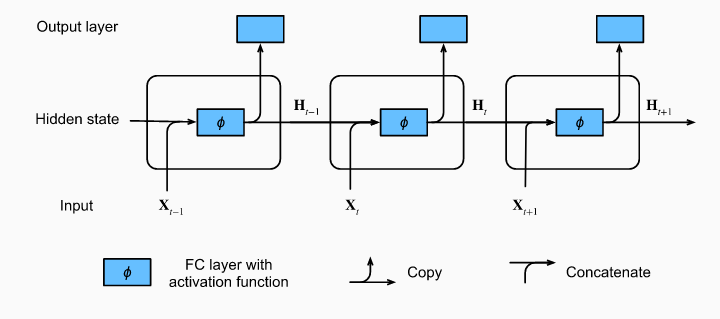

The following equations are used to compute output and new hidden state:

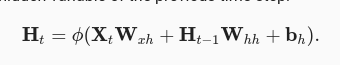
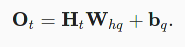

Layer that implements first equation is provided by torch.nn.RNN.
Second equation is just a linear classifier. Activation function for the recursive layer is going to be tanh.

Each character will be encoded as one hot vector.

Recursive layer implementation is provided by torch.nn.RNN.

This function takes 2 parameters: 

 - Input tensor
 - Initial state for each element in the batch
 
Each character in the sequence is a one hot vector, so the entire sequence is represente as a matrix and batch is a 3D tensor with shape $(N,L,H_{in})$

Initial state for each sequence is a 1D vector so initial hidden state for all elements in the batch is a matrix with shape $(1, N, H_{out})$.

Where

 - $N$ - batch size
 - $L$ - length of the sequence
 - $H_{in}$ - size of the input (size of the one hot vector)
 - $H_{out}$ - size of the hidden state vector.

Here is the implementation of the model:

In [16]:
class RNN(nn.Module):
    def __init__(self, hidden_state_size, vocab_size,
                 device, **kwargs):
        super(RNN, self).__init__(**kwargs)
        
        self.hidden_state_size = hidden_state_size
        self.vocab_size = vocab_size
        self.device = device
        
        self.recursive_layer = nn.RNN(vocab_size, hidden_state_size)
        self.classifier_layer = nn.Linear(hidden_state_size, vocab_size)
    
    def forward(self, inputs, initial_state):
        X = torch_fn.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.recursive_layer(X, initial_state)
        
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        
        output = self.classifier_layer(Y.reshape((-1, Y.shape[-1])))
        return output, state
        
    def gen_initial_state(self, batch_size):
        return torch.zeros((1, batch_size, self.hidden_state_size),
                           device=self.device)

In [17]:
net = RNN(256, vocab.size, device)
net = net.to(device)

In [18]:
initial_state = net.gen_initial_state(256)

In [19]:
data_loader = SeqDataLoader(dataset, 256, 40, device)
x,y = next(iter(data_loader))

output, state = net(x, initial_state)

In [20]:
output.shape

torch.Size([10240, 37])

In [21]:
output

tensor([[ 0.0214,  0.0520, -0.0006,  ...,  0.0913, -0.0288,  0.0770],
        [ 0.0307,  0.0142,  0.0011,  ...,  0.1044, -0.0492,  0.0496],
        [ 0.0307,  0.0142,  0.0011,  ...,  0.1044, -0.0492,  0.0496],
        ...,
        [ 0.0148, -0.0120, -0.0188,  ...,  0.1389, -0.0346,  0.0626],
        [ 0.0583, -0.0299,  0.0256,  ...,  0.1404, -0.0290,  0.0635],
        [ 0.0431,  0.0043, -0.0095,  ...,  0.1083, -0.0526,  0.0646]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [22]:
y.shape

torch.Size([256, 40])

10240 comes from the fact that we now have all sequences in batches in order as a one big sequence to simplify the use of the output.
Each row is a vector of logits of probabilities that a character will be next element in the sequence.

## Making predictions

Now let's build a function that will allow us to make predictions by first running the provided string throught the model to "warm it up" and then feeding the output into the input of the network and propagating the state to generate new data.

In [23]:
def gen_predictions(net, device, vocabulary, input_str, preds_count):
    torch.set_grad_enabled(False)
    tokens = [token for token in input_str]
    indexes = vocabulary.tokens_to_indexes(tokens)
    net_input = torch.tensor(indexes, dtype=torch.int16, device=device)
    net_input = net_input.expand(1, -1)
    initial_state = net.gen_initial_state(1)
    
    # Warm up with the provided string.
    outputs, state = net(net_input, initial_state)
    
    get_idx = lambda logits: logits.argmax().expand(1, 1)
    to_token = lambda idx_tensor: int(idx_tensor[0][0].cpu())
    
    # Get output
    last_index = get_idx(outputs[-1:])
    
    # Generate new result.
    output_tokens = [to_token(last_index)]
    
    for _ in range(preds_count):
        outputs, state = net(last_index, state)
        last_index = get_idx(outputs)
        output_tokens.extend([to_token(last_index)])
    
    output_chars = vocabulary.indexes_to_tokens(output_tokens)
    
    for char in output_chars:
        input_str += char
    
    torch.set_grad_enabled(True)
    
    return input_str
    

In [24]:
gen_predictions(net, device, vocab, "journey", 80)

'journey8zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'

As expected untrained network is not doing well. Now let's train it.

## Perplexity

But first we will create a metric that will tell us how well the model is doing so we can monitor this metric during training.
The standard quantity used for language models is called perplexity and it is defined by the following formula:

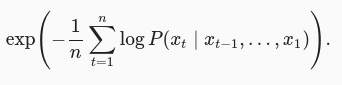

Perplexity can be best understood as the harmonic mean of the number of real choices that we have when deciding which token to pick next. Let us look at a number of cases:

 - In the best case scenario, the model always perfectly estimates the probability of the label token as 1. In this case the perplexity of the model is 1.
 - In the worst case scenario, the model always predicts the probability of the label token as 0. In this situation, the perplexity is positive infinity.
 - At the baseline, the model predicts a uniform distribution over all the available tokens of the vocabulary. In this case, the perplexity equals the number of unique tokens of the    vocabulary. In fact, if we were to store the sequence without any compression, this would be the best we could do to encode it. Hence, this provides a nontrivial upper bound that    any useful model must beat.



## Training loop

Training loop will look similar to other networks but it has two major differences

First difference is the fact that we need to somehow handle internal state. Because we are using Sequential Partitioning we are going to initialize internal state at the beginning of each epoch and then preseve it between minibatches. This means that we will need to detach the internal state from the computational graph otherwise graph will continue to grow as we compute more and more minibatches.

Second difference is the fact that we will need to somehow address the problem of exploding gradients. The effective size of the network is very deep. The depth is going to be equal to the sequence length. This will almost certanly cause exploding gradients problem and result in numerical instability of the optimization proces.

To fix this when norm of the gradient will exceed certain threshold we will normalize gradient value to a multidimensional sphere of size equal that threshold. This will keep the direction of the update but will prevent large update of the parameter.

Here is the function for performing gradient clipping.

In [25]:
def clip_gradients(model, threshold):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > threshold:
        for param in params:
            param.grad[:] *= threshold / norm

And here is the training loop.

For the loss function we will use cross entropy loss since we want to maximize the probability that predictions of next characters are correct.
For optimizer we will use SGD.

In [26]:
def train_model(net, dataset, optimizer, batch_size, seq_len, epochs):
    loss = nn.CrossEntropyLoss()
    data_loader = SeqDataLoader(dataset, batch_size, seq_len, device)
    
    loss_history = []
    perplexity_history = []
    for epoch in tqdm(range(epochs)):
        state = None
        
        total_loss = 0.
        total_sample_number = 0
        for X,Y in data_loader:
            if state is None:
                state = net.gen_initial_state(batch_size)
            else:
                state.detach_()
            
            y_hat, state = net(X, state)
        
            # Loss will be computed for each sequence we compute mean loss
            # across all sentences.
            y = Y.T.reshape(-1)
            l = loss(y_hat, y.long()).mean()
            
            optimizer.zero_grad()
            l.backward()
            clip_gradients(net, 1)
            optimizer.step()
            
            with torch.no_grad():
                total_loss += l.cpu() * y.cpu().numel()
                total_sample_number += y.cpu().numel()
        
        loss_avg = total_loss / total_sample_number
        perplexity_avg = math.exp(loss_avg)
        loss_history.append(loss_avg)
        perplexity_history.append(perplexity_avg)
        
    return {"loss": loss_history, "perplexity": perplexity_history}

In [27]:
lr = 1
batch_size = 256
sequence_len = 40
epochs = 200

net = RNN(512, vocab.size, device)
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr)

history = train_model(net, dataset, optimizer, batch_size, sequence_len, epochs)

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0, 0.5, 'loss')

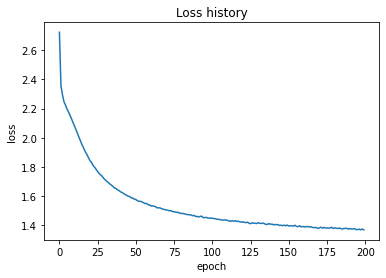

In [28]:
plt.title("Loss history")
plt.plot(history["loss"])
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'perplexity')

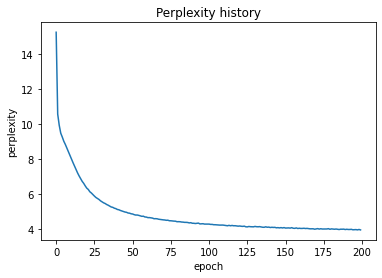

In [29]:
plt.title("Perplexity history")
plt.plot(history["perplexity"])
plt.xlabel("epoch")
plt.ylabel("perplexity")

## Some examples and conclusions

Now let's have some fun and give network diferent sentences to extend.

In [30]:
gen_predictions(net, device, vocab, "journey to the", 200)

'journey to the sea and in the streets and strange and and at a dread and said had and made a great deal of the sea and in the streets and strange and and at a dread and said had and made a great deal of the sea and '

In [43]:
gen_predictions(net, device, vocab, "before starting afresh i thought a wash would do me good", 200)

'before starting afresh i thought a wash would do me good and made him and was not a strange and and at a crew of a sure of the strength with such a man who had been able to see in the stream of a sume and in a few moments of a great deal of silence said cyr'

In [38]:
gen_predictions(net, device, vocab, "towards four oclock", 200)

'towards four oclock said my uncle and in a few moments of a few moments of a great deal of silence said cyrus harding and his companions had already all that is to see a vast clouds in a strange and and at a crew of a se'

In [39]:
gen_predictions(net, device, vocab, "captain nemo", 200)

'captain nemo had been struck with a strange and and at a crew of a sure of the strength with such a man who had been able to see in the stream of a sume and in a few moments of a great deal of silence said cyrus h'

As we can see AI learned to generate words and some basic language structures quite well but it does not have the ability to generate coherent sentences.

Interesting observation is RNN can overfit like any other neural network. When that happens it will start to generate very similar sentences in response to different starting sequences. It also tends to gravitate towards certain sentences.

Another interesting observation is that network can get stuck and start to generate the same sentence over and over again.